# Module 1 Code

In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt

Load and display the data

In [2]:
ct_sino = np.load("../data/Module1/ct_sinogram.npy")
pet_sino = np.load("../data/Module1/pet_sinogram.npy")

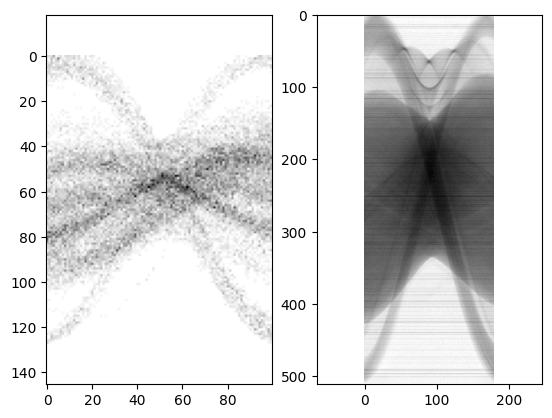

In [3]:
# Display
plt.figure()
plt.subplot(121)
plt.imshow(pet_sino,cmap="gray_r") 
plt.axis("equal")
plt.subplot(122)
plt.imshow(ct_sino, cmap="gray")
plt.axis("equal")

plt.show()

### Exercise 1.1

Load and display the data

In [4]:
dark_field = np.load("../data/Module1/ct_dark.npy")
flat_field = np.load("../data/Module1/ct_flat.npy")

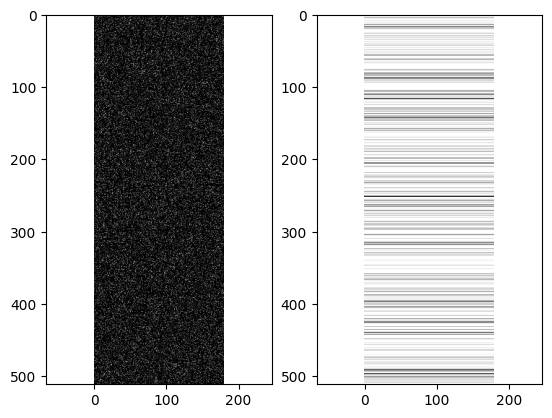

In [5]:
# Display
plt.figure()
plt.subplot(121)
plt.imshow(dark_field,cmap="gray")
plt.axis("equal")
plt.subplot(122)
plt.imshow(flat_field, cmap="gray")
plt.axis("equal")

plt.show()

Clean up CT sinogram using $S' = \frac{S-D}{F-D}$ where $S'$ is the cleaned sinogram, $S$ is the original sinogram, $D$ is the dark field, and $F$ is the flat field. Also show a comparison

In [6]:
clean_ct_sino = (ct_sino - dark_field)/(flat_field - dark_field)

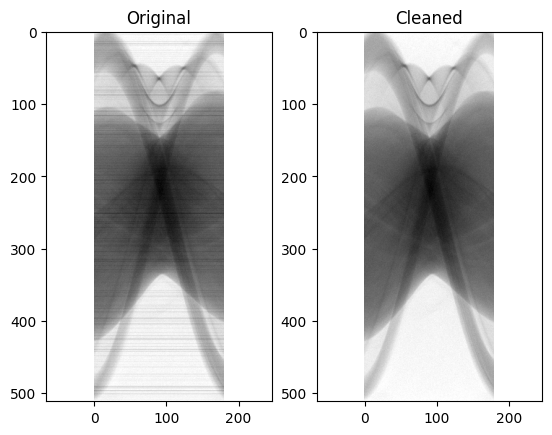

In [7]:
# Display
plt.figure()
plt.subplot(121)
plt.imshow(ct_sino,cmap="gray") 
plt.title("Original")
plt.axis("equal")
plt.subplot(122)
plt.imshow(clean_ct_sino, cmap="gray")
plt.title("Cleaned")
plt.axis("equal")

plt.show()

Load PET calibration sinogram and use it to clean PET sinogram by applying the equation, $P'=\frac{P}{C}$ where $P'$ is the cleaned sinogram, $P$ is the original sinogram, and $C$ is the calibration sinogram. Also show a comparison

In [8]:
pet_calib = np.load("../data/Module1/pet_calibration.npy")

In [9]:
clean_pet_sino = pet_sino/pet_calib

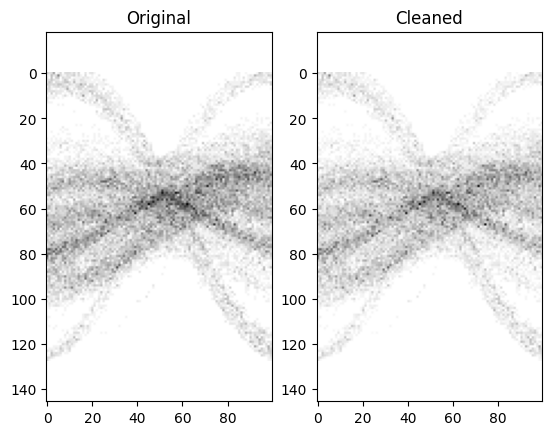

In [10]:
# Display
plt.figure()
plt.subplot(121)
plt.imshow(pet_sino,cmap="gray_r") 
plt.title("Original")
plt.axis("equal")
plt.subplot(122)
plt.imshow(clean_pet_sino, cmap="gray_r")
plt.title("Cleaned")
plt.axis("equal")

plt.show()

### Exercise 1.2

In [11]:
from skimage.transform import radon, iradon

In [12]:
theta = np.linspace(0., 180., 180, endpoint=False)

Reconstruct the image with Filtered Back Projection using different filters and display the results

In [13]:
def fbp(sinogram, angles, colour_map):
    """
    Perform Filtered Back Projection reconstruction for different filters and display the results

    Parameters
    - sinogram (array): sinogram used for reconstruction
    - angles (array): angles used for the reconstruction
    - colour_map (str): colour map to use for display (CT uses gray, PET uses colours)
    
    """
    filters = [None, 'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann'] # choice of fbp filters

    rows, cols = 2, 3  
    fig, ax = plt.subplots(rows, cols, figsize=(8, 6))
    row = 0
    col = 0

    for i, filter_name in enumerate(filters):

        row, col = divmod(i, cols) # get row and column to plot the images in the correct subplots 

        recon = iradon(sinogram, theta=angles, filter_name=filter_name)
        ax[row, col].imshow(recon, cmap=colour_map) # display the reconstructed image
        ax[row, col].set_title(f"Filter: {filter_name}")

    plt.tight_layout()
    plt.show()

    return recon


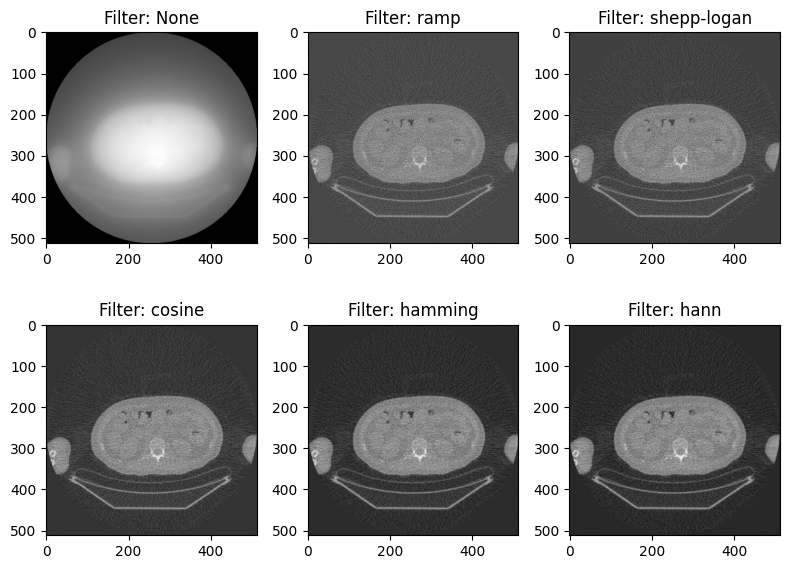

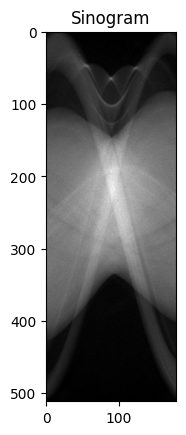

In [14]:
ct_recon = fbp(-np.log(clean_ct_sino), theta, 'gray') # use Beer-Lambert equation (don't need I0 as flat field contains it and we used flat field already)

plt.imshow(-np.log(clean_ct_sino),cmap="gray") 
plt.title("Sinogram")
plt.show()

In [15]:
def gen_random_angles():
    """
    Generate 10 subsets consisting of random angles between 0-180 without replacement

    Returns
    - set_of_angles (array): array of 10 random angle subsets
    """

    angles = np.linspace(0, 180, num=180, endpoint=False, dtype=int)  # Ensure 180 values

    # Shuffle the array randomly
    np.random.shuffle(angles)
    # Split into 10 sub-arrays
    set_of_angles = np.array_split(angles, 10)


    return set_of_angles

def os_sart_recon(sinogram, angles, gamma, k):
    """
    Perform the OS-SART iterative reconstruction method
    
    Parameters
    - sinogram (array): sinogram 
    - angles (array): list of subset angles to be used for the reconstruction
    - gamma (float): scaling factor
    - k (int): number of iterations

    Returns
    - reconstruction (array): reconstructed image
    """

    reconstruction = np.zeros(ct_recon.shape)

    for iteration in range(k):

        seq_index = iteration % len(angles)
        subset_angles = angles[seq_index]
        subset_projections = sinogram[:, subset_angles]

        residual = radon(reconstruction, theta=subset_angles) - subset_projections 
    
        update = gamma * iradon(residual, theta=subset_angles, filter_name=None) 

        reconstruction += update

    return reconstruction

Reconstruct the image with OS-SART reconstruction and display the results

In [16]:
angles = gen_random_angles()

reconstruction = os_sart_recon((-np.log(clean_ct_sino)), angles, -0.001, 100)

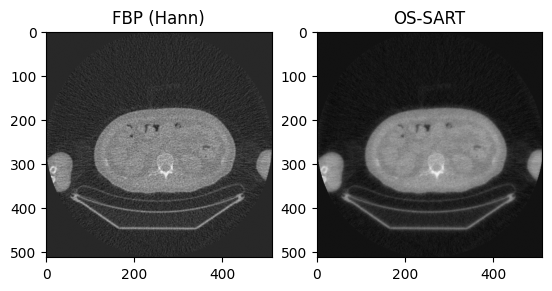

In [17]:
# Display
plt.figure()
plt.subplot(121)
plt.imshow(ct_recon, cmap="gray") 
plt.title("FBP (Hann)")

plt.subplot(122)
plt.imshow(reconstruction, cmap="gray")
plt.title("OS-SART")
plt.show()

Forward projection: Compute the estimated projections of the current reconstruction.

Compute correction: Find the difference between real and estimated projections.

Backprojection: Spread correction back to update the image.

Final Reconstruction: The reconstructed image is displayed.

**EXTRA**

Compare OS-SART and SIRT

In [18]:
import time

In [19]:
def compare_SIRT_and_os_sart(sinogram, angles, gamma_os_sart, theta, gamma_sirt, k):
    """
    Perform SIRT and OS-SART reconstruction methods for comparison
    
    Parameters
    - sinogram (array): sinogram 
    - angles (array): array of subset angles to be used for the reconstruction
    - gamma_os_sart (float): scaling factor for OS-SART update equation
    - theta (array): angles used for SIRT reconstruction
    - gamma_sirt (float): scaling factor for the SIRT update equation
    - k (int): number of iterations

    Returns
    - os_sart_reconstruction (array): OS-SART reconstructed image
    - sirt_reconstruction (array): SIRT reconstructed image
    """

    os_sart_reconstruction = np.zeros(ct_recon.shape)
    sirt_reconstruction = np.zeros(ct_recon.shape)
    tot_os_time = 0
    tot_sirt_time = 0
    for iteration in range(k):

        start_os = time.time()

        seq_index = iteration % len(angles)
        subset_angles = angles[seq_index]
        subset_projections = sinogram[:, subset_angles]
   
        residual_os_sart = radon(os_sart_reconstruction, theta=subset_angles) - subset_projections 
        update_os_sart = gamma_os_sart * iradon(residual_os_sart, theta=subset_angles, filter_name=None) 

        os_sart_reconstruction += update_os_sart

        os_time = time.time() - start_os
        tot_os_time += os_time


        start_sirt = time.time()

        residual_sirt = -np.log(clean_ct_sino) - radon(sirt_reconstruction, theta)
        
        gradient_sirt = gamma_sirt * iradon(residual_sirt, theta, filter_name = None) 
        sirt_reconstruction += gradient_sirt

        sirt_time = time.time() - start_sirt
        tot_sirt_time += sirt_time


        if iteration % 10 == 0: # display every 10 iterations to monitor convergence

            plt.figure()
            plt.subplot(121)
            plt.imshow(os_sart_reconstruction, cmap="gray") 
            plt.title("OS-SART (iteration " + str(iteration) + ")")

            plt.subplot(122)
            plt.imshow(sirt_reconstruction, cmap="gray")
            plt.title("SIRT (iteration " + str(iteration) + ")")
            plt.show()

    return os_sart_reconstruction, sirt_reconstruction, tot_os_time, tot_sirt_time

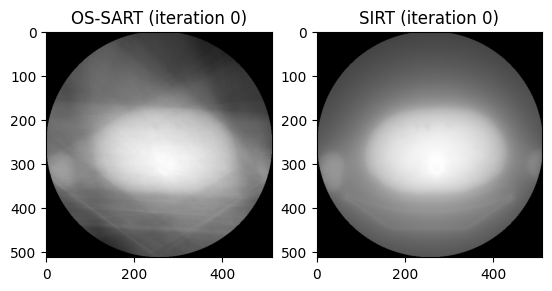

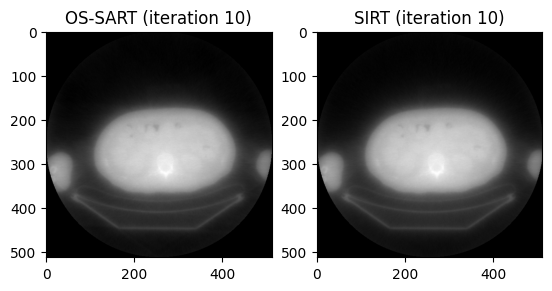

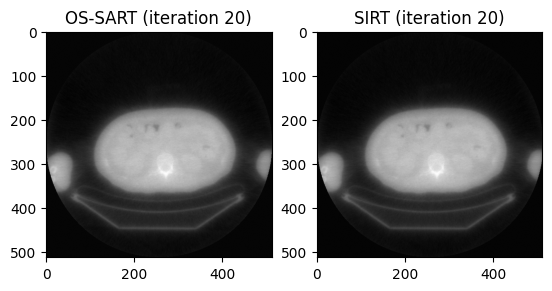

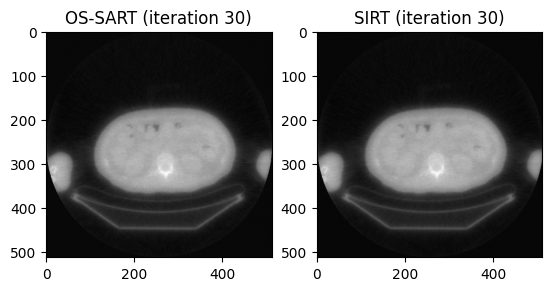

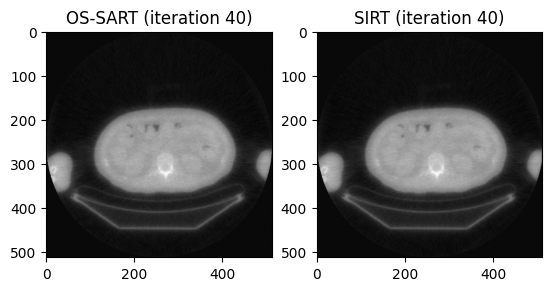

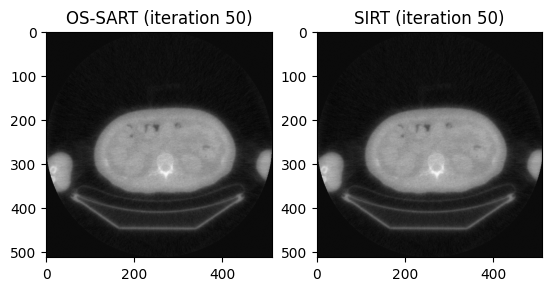

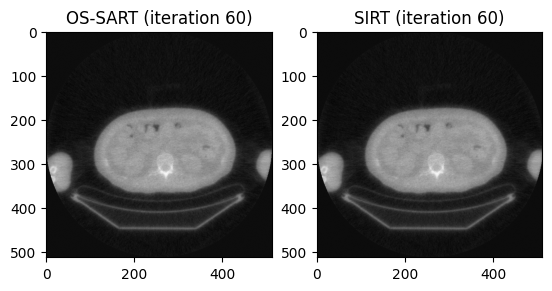

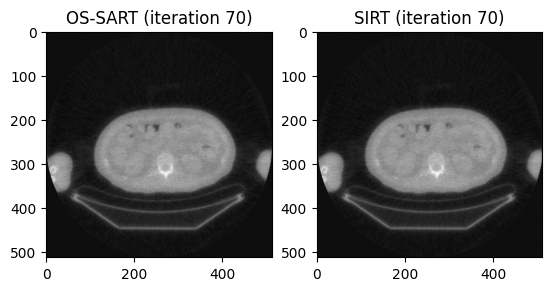

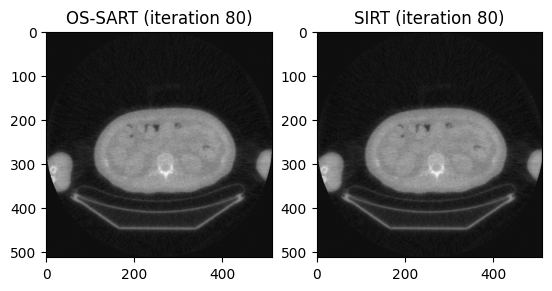

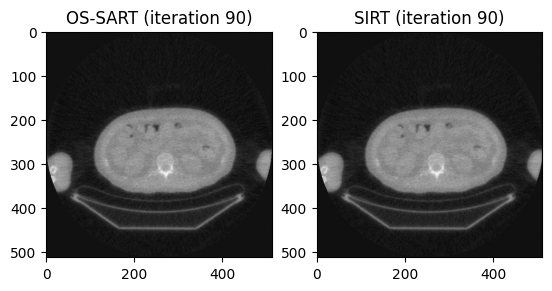

In [20]:
os_sart_reconstruction, sirt_reconstruction, tot_os_time, tot_sirt_time = compare_SIRT_and_os_sart((-np.log(clean_ct_sino)), angles, -0.001, theta, 0.001, 100) # perform comparison

In [21]:
print("The total time taken for OS-SART reconstruction is: ", tot_os_time, " seconds")
print("The total time taken for SIRT reconstruction is: ", tot_sirt_time, " seconds")

The total time taken for OS-SART reconstruction is:  6.755394220352173  seconds
The total time taken for SIRT reconstruction is:  64.73565340042114  seconds


Display all the reconstructions side by side

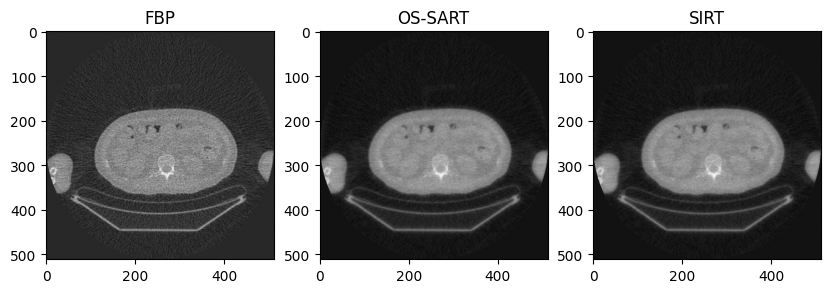

In [22]:
# Display
plt.figure(figsize=(10,20))
plt.subplot(131)
plt.imshow(ct_recon, cmap="gray") 
plt.title("FBP")

plt.subplot(132)
plt.imshow(reconstruction, cmap="gray")
plt.title("OS-SART")

plt.subplot(133)
plt.imshow(sirt_reconstruction, cmap="gray")
plt.title("SIRT")
plt.show()

### Exercise 1.3

In [23]:
from skimage.transform import resize

Resize the CT image to the size of the PET image

In [24]:
pet_pixel_size = 4.24
ct_pixel_size = 1.06

scale = ct_pixel_size / pet_pixel_size

In [25]:
resized_ct = resize(reconstruction, (reconstruction.shape[0]*scale, reconstruction.shape[1]*scale))

Produce a sinogram and get attenuation array

In [26]:
binned_theta = np.linspace(0., 180.,100, endpoint=False)
resized_ct_sinogram = radon(resized_ct, theta=binned_theta)

attenuation = np.exp(resized_ct_sinogram)

/Users/panosantonopoulos/Desktop/CAMBRIDGE DiS/Lent/A2_Medical_Imaging/COURSEWORK/pa517/venvs/A2_VENV/lib/python3.11/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


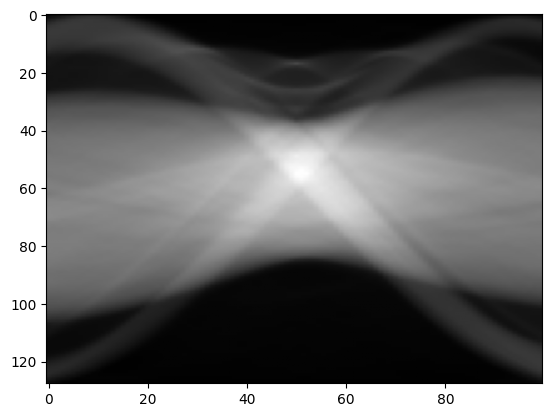

In [27]:
plt.figure()
plt.imshow(resized_ct_sinogram, cmap='gray', aspect='auto')
plt.show()

Use the attenuation array to attenuation correct the PET sinogram

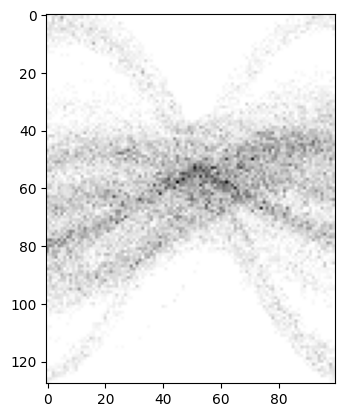

In [28]:
att_corr_pet_sino = attenuation * clean_pet_sino
plt.imshow(att_corr_pet_sino, cmap='gray_r')

### Exercise 1.4

First, reconstruct the PET image using FBP

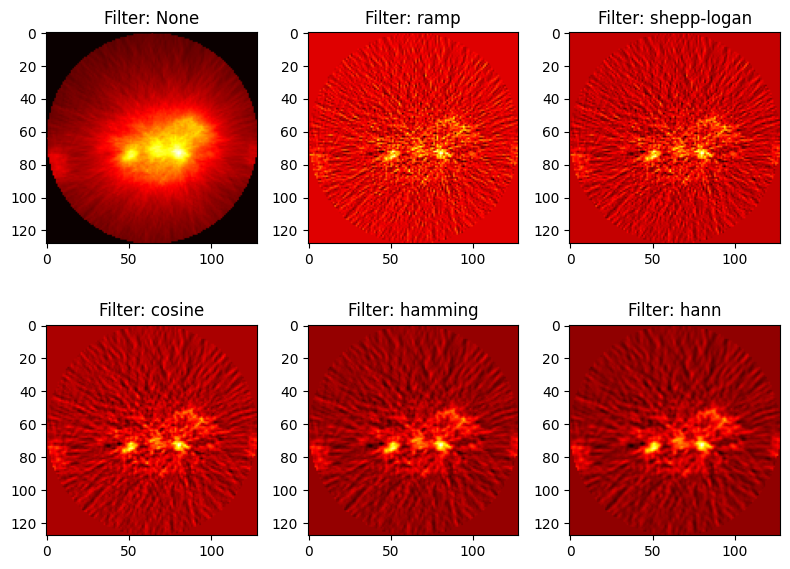

In [29]:
pet_recon_fbp = fbp(att_corr_pet_sino, np.linspace(0, 180, 100, endpoint=False), 'hot')

In [30]:
def gen_random_angles_pet():
    """
    Generate 10 subsets consisting of random angles between 0-100 without replacement

    Returns
    - set_of_angles (array): array of 10 random angle subsets
    """

    angles = np.linspace(0, 100, num=100, endpoint=False, dtype=int) 
    np.random.shuffle(angles) # shuffle the array randomly
    set_of_angles = np.array_split(angles, 10) # split into 10 subsets

    return set_of_angles

def osem_reconstruction(sinogram, angles, k):
    """
    Perform OSEM reconstruction

    Parameters
    - sinogram (array): sinogram used for reconstruction
    - angles (array): array of subset angles to be used for the reconstruction
    - k (int): number of iterations 

    Returns
    - reconstruction (array): reconstructed image
    """

    reconstruction = np.ones(resized_ct.shape)

    for iteration in range(k):

        seq_index = iteration % len(angles)
        subset_angles = angles[seq_index]
        subset_projections = sinogram[:, subset_angles]
        
        ratio = subset_projections / (radon(reconstruction, theta=subset_angles*1.8) + 1e-10) # multiply angles by 1.8 to account for the sinogram binning 
        
        update = iradon(ratio, theta=subset_angles*1.8, filter_name=None) 

        reconstruction = reconstruction * update

    return reconstruction

def mlem_reconstruction(sinogram, theta, k):
    """
    Perform MLEM reconstruction

    Parameters
    - sinogram (array): sinogram used for reconstruction
    - theta (array): array of angles to be used for the reconstruction
    - k (int): number of iterations 

    Returns
    - reconstruction (array): reconstructed image
    """

    reconstruction = np.ones(resized_ct.shape)

    for iteration in range(k):
        
        ratio = sinogram / (radon(reconstruction, theta=theta*1.8) + 1e-10) # multiply angles by 1.8 to account for the sinogram binning 
        
        update = iradon(ratio, theta=theta*1.8, filter_name=None) 

        reconstruction = reconstruction * update

    return reconstruction

Perform OSEM reconstruction

In [31]:
angles = gen_random_angles_pet()

pet_recon = osem_reconstruction(att_corr_pet_sino+1e-10, angles, 100)

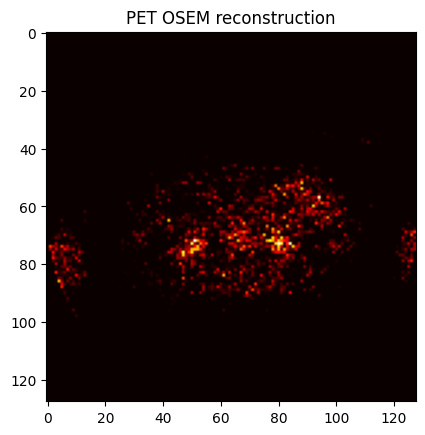

In [32]:
plt.imshow(pet_recon, cmap='hot')
plt.title("PET OSEM reconstruction")
plt.show()

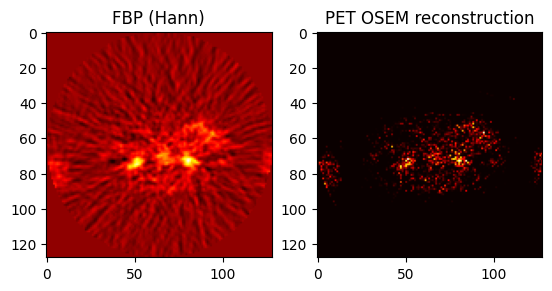

In [33]:
# Display
plt.figure()
plt.subplot(121)
plt.imshow(pet_recon_fbp, cmap="hot") 
plt.title("FBP (Hann)")

plt.subplot(122)
plt.imshow(pet_recon, cmap="hot")
plt.title("PET OSEM reconstruction")
plt.show()

**EXTRA** 

Comparing OSEM and MLEM

In [34]:
pet_recon_mlem = mlem_reconstruction(att_corr_pet_sino+1e-10, np.linspace(0,100,100,endpoint=False), 100)

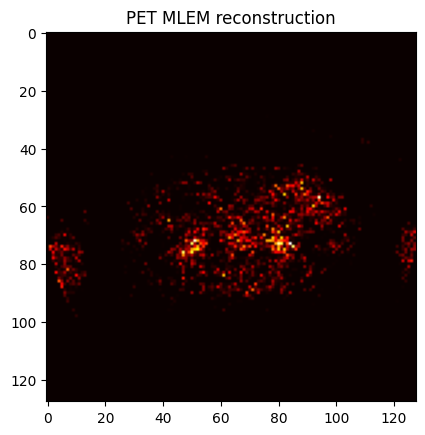

In [35]:
plt.imshow(pet_recon_mlem, cmap='hot')
plt.title("PET MLEM reconstruction")
plt.show()

In [36]:
def compare_osem_and_mlem(sinogram, angles, theta, k):
    """
    Compare the OSEM and MLEM reconstruction methods

    Parameters
    - sinogram (array): sinogram used for reconstruction
    - angles (array): array of subset angles to be used for the OSEM reconstruction
    - theta (array): array of angles to be used for the MLEM reconstruction
    - k (int): number of iterations

    Returns
    - reconstruction_osem (array): reconstruction using OSEM
    reconstruction_mlem (array): reconstruction using MLEM
    """

    reconstruction_osem = np.ones(resized_ct.shape) # initialise arrays
    reconstruction_mlem = np.ones(resized_ct.shape)
    tot_osem_time = 0
    tot_mlem_time = 0
    for iteration in range(k):

        start_osem = time.time()

        seq_index = iteration % len(angles)
        subset_angles = angles[seq_index]
        subset_projections = sinogram[:, subset_angles]
        
        ratio_osem = subset_projections / (radon(reconstruction_osem, theta=subset_angles*1.8) + 1e-10) # multiply angles by 1.8 to account for the sinogram binning 
        
        update_osem = iradon(ratio_osem, theta=subset_angles*1.8, filter_name=None) 

        reconstruction_osem = reconstruction_osem * update_osem

        osem_time = time.time() - start_osem
        tot_osem_time += osem_time


        start_mlem = time.time()

        ratio_mlem = sinogram / (radon(reconstruction_mlem, theta=theta*1.8) + 1e-10) # multiply angles by 1.8 to account for the sinogram binning 
        
        update_mlem = iradon(ratio_mlem, theta=theta*1.8, filter_name=None) 

        reconstruction_mlem = reconstruction_mlem * update_mlem

        mlem_time = time.time() - start_mlem
        tot_mlem_time += mlem_time


        if iteration % 10 == 0: # display reconstructions every 10 iterations to monitor convergence

            plt.figure(figsize=(10,20))
            plt.subplot(121)
            plt.imshow(reconstruction_osem, cmap='hot') 
            plt.title('OSEM (iteration ' + str(iteration) + ' )')

            plt.subplot(122)
            plt.imshow(reconstruction_mlem, cmap='hot')
            plt.title('MLEM (iteration ' + str(iteration) + ' )')

            plt.show()

    return reconstruction_osem, reconstruction_mlem, tot_osem_time, tot_mlem_time

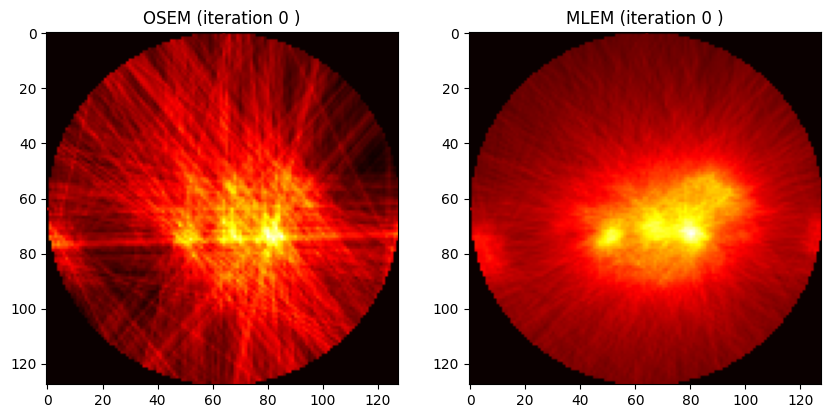

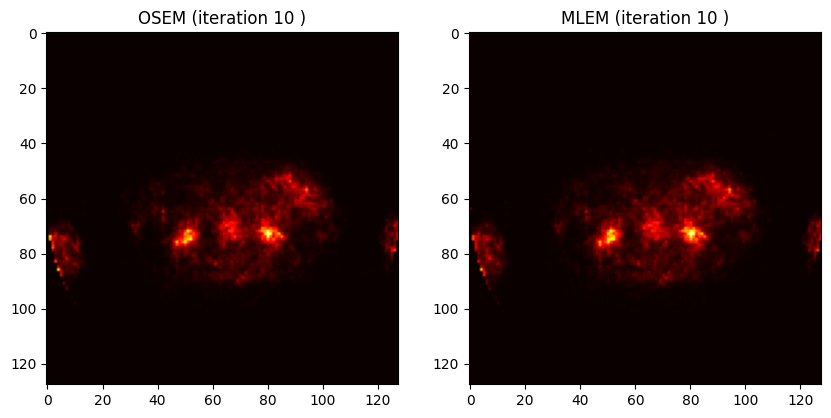

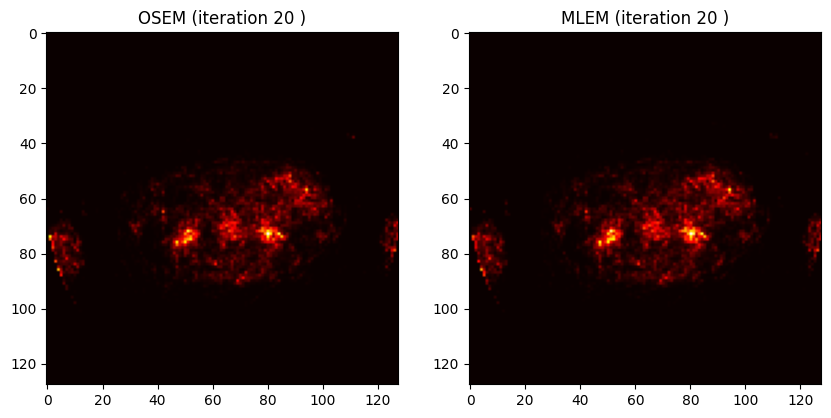

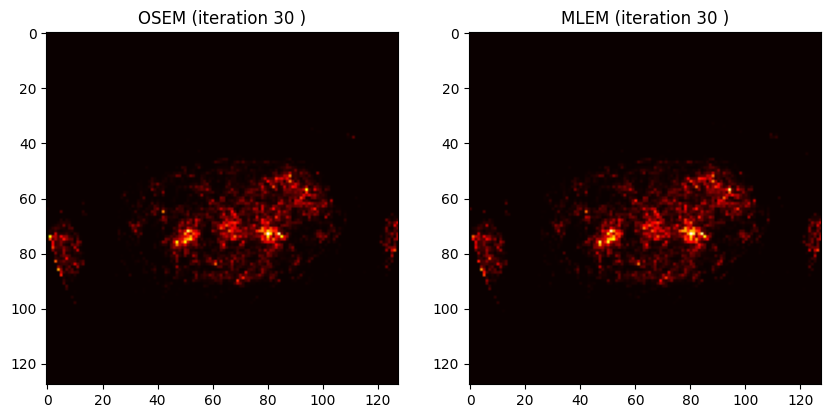

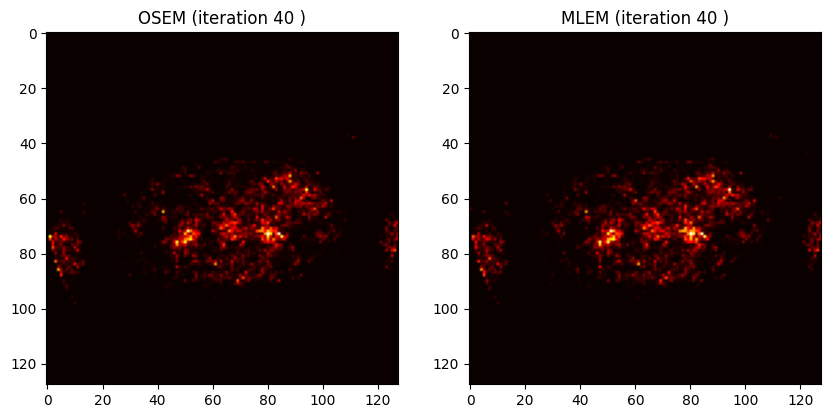

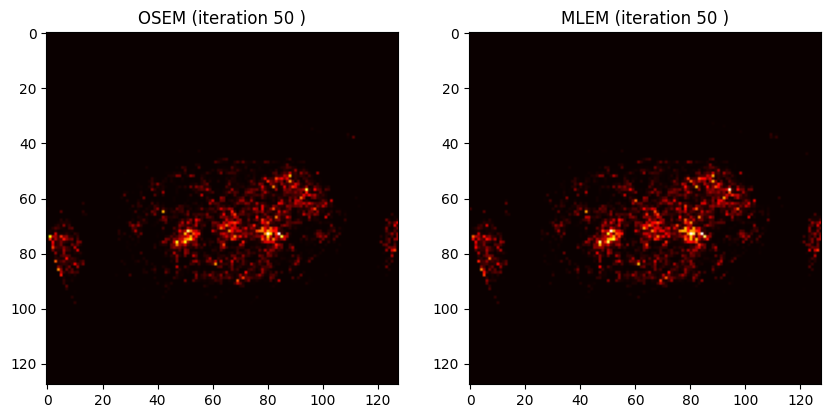

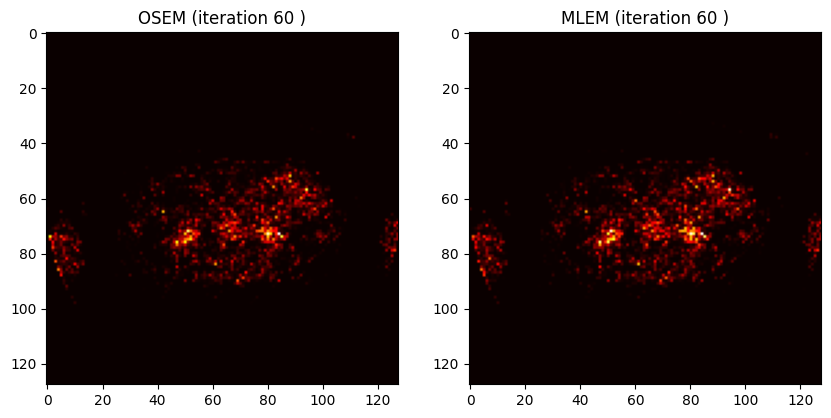

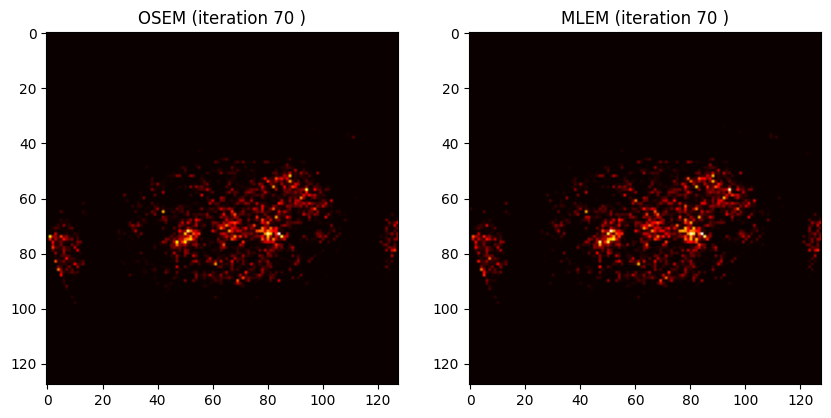

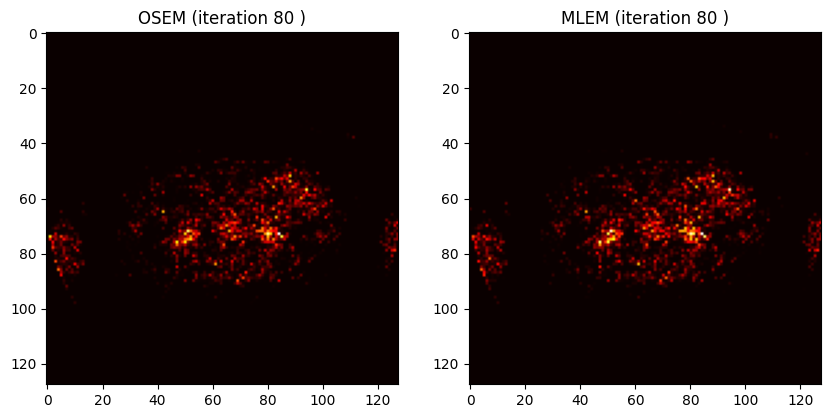

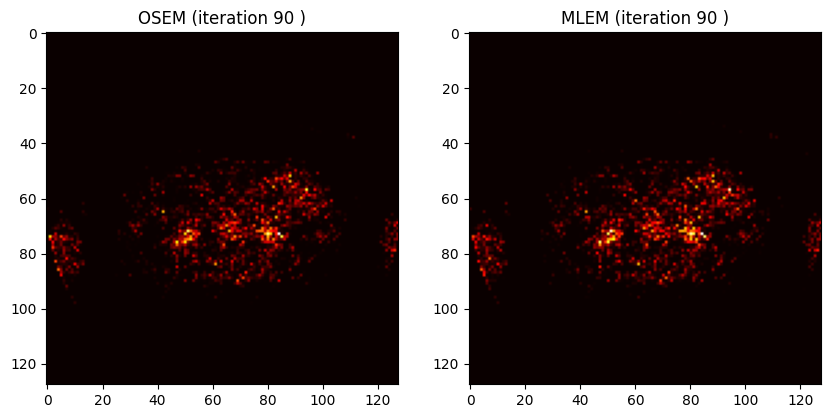

In [37]:
reconstruction_osem, reconstruction_mlem, tot_osem_time, tot_mlem_time = compare_osem_and_mlem(att_corr_pet_sino+1e-10, angles, np.linspace(0,100,100,endpoint=False), 100)

In [38]:
print("The total time taken for OSEM reconstruction is: ", tot_osem_time, " seconds")
print("The total time taken for MLEM reconstruction is: ", tot_mlem_time, " seconds")

The total time taken for OSEM reconstruction is:  0.26673436164855957  seconds
The total time taken for MLEM reconstruction is:  2.4185078144073486  seconds


### Exercise 1.5

##### 1.5.1 Display the PET and CT scans overlayed

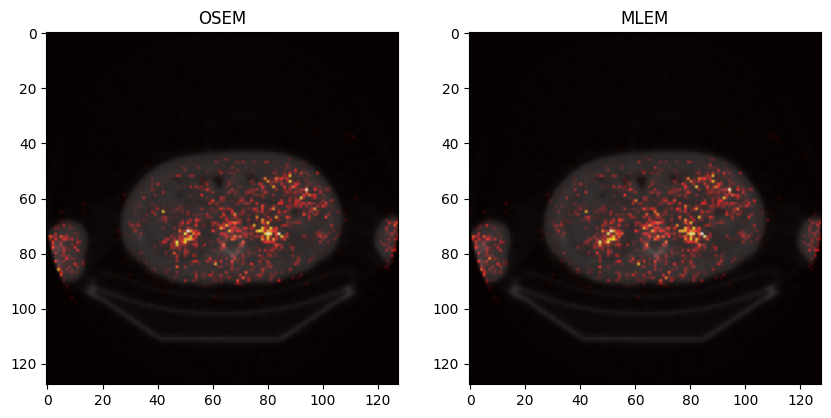

In [39]:
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(resized_ct, cmap='gray')
plt.imshow(pet_recon, cmap='hot', alpha=0.7)
plt.title('OSEM')

plt.subplot(122)
plt.imshow(resized_ct, cmap='gray')
plt.imshow(pet_recon_mlem, cmap='hot', alpha=0.7)
plt.title('MLEM')

plt.show()